In [1]:
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns

In [2]:
mainpath = 'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS'
dic_cenarios = {
                # 'MPA FNS Lim Scenario 2022' : f'{mainpath}/MPV_(FNS Lim)_RC/',
                # 'V1A1F2 Scenario 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F3 Scenario 2026' :f'{mainpath}/V1A1F3_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F4 Scenario 2026' :f'{mainpath}/V1A1F4_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F5 Scenario 2026' :f'{mainpath}/V1A1F5_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F2 Scenario 2026 rev2' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev2_2026/',
                # 'V2A2F2 Scenario 2026' :f'{mainpath}/V2A2F2_REV02_2026/',
                # 'V2A2F3 Scenario 2026' :f'{mainpath}/V2A2F3_REV02_2026/',
                # 'V2A2F4 Scenario 2026' :f'{mainpath}/V2A2F4_REV02_2026/',
                # 'V2A2F5 Scenario 2026' :f'{mainpath}/V2A2F5_REV02_2026/',
                'V3A3F2 Scenario 2026 rev1' :f'{mainpath}/V3A3F2_REV0_2026/',
                'V3A3F3 Scenario 2026 rev1' :f'{mainpath}/V3A3F3_REV0_2026/',
                'V3A3F4 Scenario 2026 rev1' :f'{mainpath}/V3A3F4_REV0_2026/',
                'V3A3F5 Scenario 2026 rev1' :f'{mainpath}/V3A3F5_REV0_2026/',
                'V3A3F2 Scenario 2026 rev1' :f'{mainpath}/V3A3F2_REV1_2026/',
                'V3A3F3 Scenario 2026 rev1' :f'{mainpath}/V3A3F3_REV1_2026/',
                'V3A3F4 Scenario 2026 rev1' :f'{mainpath}/V3A3F4_REV1_2026/',
                'V3A3F5 Scenario 2026 rev1' :f'{mainpath}/V3A3F5_REV1_2026/',
                }

dirGeral = 'StaticAnalysis/Data/Geral/'
# dirIndice = 'StaticAnalysis/Data/Indice_n_supremo/'
dirIndice = 'StaticAnalysis/Data/Indice_n_2/'
dirRamos = 'StaticAnalysis/Data/Fluxo em Ramos/'
dirPotencia = 'StaticAnalysis/Data/Potencia/'

filenames = [
                (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                (dirRamos + 'DF_HVDC.csv', 'HVDC'), 
                (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'), 
                (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'),  
                (dirPotencia+'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'), 
                (dirPotencia+'Df_Reserva_PO_MVAR.csv', 'pot_mvar_reserv'),
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
            ]

intense_palette = sns.color_palette("bright", 10)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}

In [3]:
# Function to calculate indices for lines
def IndiceLinhas(df, n):
    df_filtered = df.loc[
        ~(df['L1(MVA)'] == 9999) & df['VBASEKV'].isin([230, 345, 440, 500, 525, 765])
    ].copy()
    df_filtered['MW_Flow'] = np.where(
        df_filtered['MW:From-To'] >= 0, df_filtered['MW:From-To'], df_filtered['MW:To-From']
    )
    df_filtered['PI_mva'] = (df_filtered['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt = df_filtered.groupby(
        ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})
    df_r = df_filtered.groupby(
        ['Dia', 'Hora', 'Cenario', 'REG']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})
    df_po = df_filtered.groupby(
        ['Dia', 'Hora', 'Cenario']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    # Calculate PFI
    for df in [df_r_nt, df_r, df_po]:
        df['PFI'] = df['MW_Flow'] / df['MVA']
        df['PI_mva'] = df['PI_mva'] ** (1 / (2 * n))

    return df_r_nt, df_r, df_po

# Function to flatten DataFrame
def flatdf(df, BG):
    df_reordered = df.reorder_levels(['Dia', 'Hora', 'Cenario', 'REG', BG])
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    df_reordered = df_reordered.rename(index=regionmap, level='REG')
    df_reordered_sorted = df_reordered.sort_index(level=['Dia', 'Hora', 'Cenario', 'REG'])
    df_reordered_sorted.rename(columns={'CSI_INF': 'DPI_inf', 'CSI_SUP': 'DPI_sup'}, inplace=True)

    lista = [[index[0], index[1], index[2]] for index in df_reordered.index]
    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))

    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['Dia', 'Hora', 'Cenario']
    
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:, :, :, reg, :].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                reg_name = 'SE-CO' if reg == 'Sudeste-Centro-Oeste' else reg
                columns.append(f"{column}_{reg_name}_{bg}")

    datapd.columns = columns
    return datapd

# Function to read data
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        lst.append(df.compute())
        return lst

    keys = [i for _, i in filenames]
    dfs = {key: [] for key in keys}
    for i, j in dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

# Funtion to obtain the main features (buses) that contribute in the DPI_1 
def computefeatures(df_nt, df_ger, dfpq, dfpv):
    # Step 1: Merge DataFrames
    datafeatures_pq = df_nt.merge(
        dfpq[['CSI_INF', 'CSI_SUP']],
        on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left'
    )[['BUS_ID', 'BUS_NAME', 'ARE', 'VBASEKV', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'B0_MVAR']]

    datafeatures_pv = df_ger.merge(
        dfpv[['CSI_INF', 'CSI_SUP']],
        on=['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'], how='left'
    )[['BUS_ID', 'BUS_NAME', 'ARE', 'Gen_Type', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'PG_MW']]

    # Step 2: Calculate Importance
    for df in [datafeatures_pq, datafeatures_pv]:
        df['Importance_inf'] = df.apply(lambda row: row['IndiceInf'] / row['CSI_INF'] if row['CSI_INF'] != 0 else 0, axis=1)
        df['Importance_sup'] = df.apply(lambda row: row['IndiceSup'] / row['CSI_SUP'] if row['CSI_SUP'] != 0 else 0, axis=1)

    # Step 3: Filter rows

    df_nt['B0_MVAR'].fillna(0, inplace=True)
    df_ger['PG_MW'].fillna(0, inplace=True)

    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'BUS_NAME': 'first'
    }).reset_index()

    dfeatures_pv = datafeatures_pv.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'Gen_Type': 'first',
        'BUS_NAME': 'first'
    }).reset_index()

    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nbuses = 3

    result_inf_pq = dfeatures_pq.groupby(['REG', 'VBASEKV']).apply(
        lambda x: x.nlargest(nbuses, 'Importance_inf')
    ).reset_index(drop=True)[['REG', 'VBASEKV', 'BUS_ID', 'Importance_inf']]

    result_sup_pq = dfeatures_pq.groupby(['REG', 'VBASEKV']).apply(
        lambda x: x.nlargest(nbuses, 'Importance_sup')
    ).reset_index(drop=True)[['REG', 'VBASEKV', 'BUS_ID', 'Importance_sup']]

    result_inf_pv = dfeatures_pv.groupby(['REG', 'Gen_Type']).apply(
        lambda x: x.nlargest(nbuses, 'Importance_inf')
    ).reset_index(drop=True)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]

    result_sup_pv = dfeatures_pv.groupby(['REG', 'Gen_Type']).apply(
        lambda x: x.nlargest(nbuses, 'Importance_sup')
    ).reset_index(drop=True)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]

    # Step 6: Filter by BUS_ID
    features_sup_pq = result_sup_pq[(result_sup_pq['Importance_sup'] != 0)]
    features_inf_pq = result_inf_pq[(result_inf_pq['Importance_inf'] != 0)]
    features_sup_pv = result_sup_pv[(result_sup_pv['Importance_sup'] != 0)]
    features_inf_pv = result_inf_pv[(result_inf_pv['Importance_inf'] != 0)]

    # Step 7: Pivot tables
    def pivot_table(df, values_list, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column='BUS_NAME'):
        filtered_df = df[df['BUS_ID'].isin(values_list)]
        pivot_df = filtered_df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df

    features_sup_pq_df = pivot_table(df_nt, features_sup_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_inf_pq_df = pivot_table(df_nt, features_inf_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_sup_pv_df = pivot_table(df_ger, features_sup_pv['BUS_ID'].to_list(), 'QG_MVAR')
    features_inf_pv_df = pivot_table(df_ger, features_inf_pv['BUS_ID'].to_list(), 'QG_MVAR')

    return features_sup_pq_df, features_inf_pq_df, features_sup_pv_df, features_inf_pv_df

# Function to filter data based on non-convergent conditions
def filtarNC(df_list):
    df_filtrado = []
    for df_ in df_list:
        cenario = df_['Cenario'][0]
        bool_PWF_NConv = df_indice_grop[
            df_indice_grop['Cenario'] == cenario
        ][['Dia', 'Hora']].apply(tuple, axis=1)
        filtro = df_[['Dia', 'Hora']].apply(tuple, axis=1).isin(bool_PWF_NConv)
        df_filtrado.append(df_[filtro])
    return df_filtrado

# Function to concatenate and process data (part 1)
def concatenation_1():
    data = {}
    print('====== Start concatenation ======')
    ddffpv = pd.concat(dfs['IndexDec_PV'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'])
    ddffpq = pd.concat(dfs['IndexDec_PQ'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'])

    Df_ger = pd.concat(dfs['ger'], axis=0)
    Df_nt = pd.concat(dfs['nt'], axis=0)
    
    print('====== Selecting Critical Buses as features ======')
    data['features_sup_pq_df'], data['features_inf_pq_df'], data['features_sup_pv_df'], data['features_inf_pv_df'] = computefeatures(Df_nt, Df_ger, ddffpq, ddffpv)

    data['df_DPI'] = pd.concat([flatdf(ddffpq, 'VBASEKV'), flatdf(ddffpv, 'Gen_Type')], axis=1)
    data['df_ger_reg_concat'] = pd.concat(filtarNC(dfs['ger_reg']), axis=0)
    data['df_indice_group'] = pd.concat(dfs['Index_Modif'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    data['df_linhas'] = pd.concat(dfs['linhas'], axis=0)

    df_intercambios_01 = pd.concat(dfs['intercambios'], axis=0).rename(columns={'Unnamed: 0': 'Intercambio'})
    df_hvdc_01 = pd.concat(dfs['HVDC'], axis=0).rename(columns={'Unnamed: 0': 'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'})
    df_Indice_REG = pd.concat(dfs['Index'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    data['df_Trafo'] = pd.concat(dfs['Trafo'], axis=0).rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
    data['df_reserva'] = pd.concat(dfs['pot_mw_reserv'], axis=0).set_index(['Dia', 'Hora', 'Cenario'])

    df_hvdc_01 = df_hvdc_01.set_index(['Dia', 'Hora', 'Cenario', 'Intercambio'])
    df_intercambios_01 = df_intercambios_01.set_index(['Dia', 'Hora', 'Cenario', 'Intercambio'])
    data['df_indice_grop'] = df_indice_grop.set_index(['Dia', 'Hora', 'Cenario'])
    data['df_indice_group'] = data['df_indice_group'].set_index(['Dia', 'Hora', 'Cenario'])
    data['df_Indice_REG'] = df_Indice_REG.set_index(['Indice', 'Dia', 'Hora', 'REG', 'Cenario'])

    concatenated_HVDC = pd.concat([
        df_hvdc_01.loc[:, :, :, 'Elo_FOZ-IBIUNA']['MW:From-To'],
        df_hvdc_01.loc[:, :, :, 'Elo_PVEL-ARARQ']['MW:From-To'],
        df_hvdc_01.loc[:, :, :, 'Elo_XINGU-SE']['MW:From-To'],
        df_hvdc_01.loc[:, :, :, 'Elo_CPVBTB-PVEL']['MW:From-To']
    ], axis=1, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE', 'Elo_CPVBTB-PVEL'])

    concatenated_FluxoAC = pd.concat([
        df_intercambios_01.loc[:, :, :, 'Fluxo_N-S']['MW:From-To'],
        df_intercambios_01.loc[:, :, :, 'Fluxo_NE-N']['MW:From-To'],
        df_intercambios_01.loc[:, :, :, 'Fluxo_NE-SE']['MW:From-To'],
        df_intercambios_01.loc[:, :, :, 'Fluxo_SUL-SECO']['MW:From-To']
    ], axis=1, keys=['Fluxo_N-S', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_SUL-SECO'])

    data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on=['Dia', 'Hora', 'Cenario'], how='left')
    return data

# Function to concatenate and process data (part 2)
def concatenation_2(data):
    print('====== Start processing (PO) ======')
    Df_ger = pd.concat(dfs['ger'], axis=0)

    Jirau = [7051, 7061]
    S_Antonio = [7050, 7062, 7064]
    Tucurui = [6419, 6420, 6422, 6424, 6425]
    B_Monte = [6729]
    Itaipu_50 = [1100]
    Itaipu_60 = [1107]
    I_Solt = [501]

    DFF_POT = data['df_ger_reg_concat'].drop(columns=['REG', 'PG_FERV']).groupby(by=['Dia', 'Hora', 'Cenario']).sum()
    df_linhas_500up = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440])]
    df_linhas_filtered = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])]

    df_linhas_grouped = df_linhas_filtered.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    df_linhas_grouped_500up = df_linhas_500up.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    df_linhas_grouped_500down = df_linhas_500down.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    
    df_linhas_grouped_500up = df_linhas_grouped_500up.rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_grouped_500down = df_linhas_grouped_500down.rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})

    DF_complete_PO = pd.concat([df_linhas_grouped_500up, df_linhas_grouped_500down, df_linhas_grouped], axis=1)
    DF_complete_PO = DF_complete_PO.merge(DFF_POT.groupby(['Dia', 'Hora', 'Cenario']).sum(), on=['Dia', 'Hora', 'Cenario'], how='left')
    DF_complete_PO = data['df_indice_group'].merge(DF_complete_PO, on=['Dia', 'Hora', 'Cenario'], how='left')

    DF_complete_PO[['Mvar:Losses_500up', '% L1_500up']] = DF_complete_PO[['Mvar:Losses_500up', '% L1_500up']].fillna(0)
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']
    DF_complete_PO['DL_MW'] = DF_complete_PO['PL_MW'] - (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL'])

    Df_ger = Df_ger[Df_ger['BUS_ID'].isin(Jirau + S_Antonio + Tucurui + B_Monte + Itaipu_50 + Itaipu_60 + I_Solt)]
    DF_complete_PO[['Jirau_MW', 'Jirau_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Jirau)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['S_Antonio_MW', 'S_Antonio_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(S_Antonio)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Tucurui_MW', 'Tucurui_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Tucurui)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['B_Monte_MW', 'B_Monte_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(B_Monte)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Itaipu_50_MW', 'Itaipu_50_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_50)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Itaipu_60_MW', 'Itaipu_60_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_60)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['I_Solt_MW', 'I_Solt_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(I_Solt)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()

    return DF_complete_PO

# Function to concatenate and process data (part 3)
def concatenation_3(data):
    print('====== Start processing (REG) ======')
    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia', 'Hora', 'REG', 'Cenario']).drop(columns='PG_FERV')
    
    df_linhas_500up = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440])]

    df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})
    
    df_Trafo_grouped_REG = data['df_Trafo'][data['df_Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])].groupby(by=['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1_Trafo': 'mean', 'Mvar:Losses_Trafo': 'sum'})
    df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)
    
    DF_complete_PO_REG = df_linhas_grouped_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

    df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
    df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
    
    df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PV = df_REG_Cenario_PV.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PV = df_REG_Cenario_PV.merge(dfl_r[['PI_mva', 'PFI']], on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

    df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    insecure_indices = df_indice_grop[df_indice_grop['DPI_PO_final'] > 100].index
    filtro = df_REG_Cenario_PV.index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(insecure_indices)

    # df_Indice_complete_PV_inseguro = df_REG_Cenario_PV[filtro]
    # df_Indice_complete_PQ_inseguro = df_REG_Cenario_PQ[filtro]
    df_Indice_complete_PV_alarme = df_REG_Cenario_PV[~filtro]
    df_Indice_complete_PQ_alarme = df_REG_Cenario_PQ[~filtro]

    Df_data_completo_reg = df_Indice_complete_PQ_alarme[['OV DPI', 'UV DPI']].merge(df_Indice_complete_PV_alarme, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0}, inplace=True)

    return Df_data_completo_reg

# Main code execution
if __name__ == '__main__':
    print('Reading data...')
    dfs = read_data()
    df_indice_grop = pd.concat(dfs['Index_PO'], axis=0)
    
    print('Concatenating data...')
    DATA = concatenation_1()

    print('Calculating loading index...')
    dfl_r_nt, dfl_r, dfl_po = IndiceLinhas(DATA['df_linhas'], 2)
    
    DF_complete_PO = concatenation_2(DATA)
    Df_data_completo_reg = concatenation_3(DATA)
    
    # Renaming regions
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    Df_data_completo_reg = Df_data_completo_reg.rename(index=regionmap, level='REG')


Reading data...
Concatenating data...
====== Start concatenation ======
====== Selecting Critical Buses as features ======


C:\Users\david\AppData\Local\Temp\ipykernel_23544\679563223.py:94: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_nt['B0_MVAR'].fillna(0, inplace=True)
C:\Users\david\AppData\Local\Temp\ipykernel_23544\679563223.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

Calculating loading index...
====== Start processing (PO) ======
====== Start processing (REG) ======


In [4]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA

In [5]:
def reorder_and_filter(df, cenario, region, columns):
    df = df.reorder_levels(['Dia', 'Hora', 'Cenario', 'REG'])[columns]
    if cenario == 'all':
        if region == 'all':
            df_reordered = df
        elif region == 'PO':
            df_reordered = df
        else:
            df_reordered = df.loc[:, :, :, region]
    else:
        if region == 'all':
            df_reordered = df.loc[:, :, cenario, :]
        elif region == 'PO':
            df_reordered = df.loc[:, :, cenario]
        else:
            df_reordered = df.loc[:, :, cenario, region]
    return df_reordered

def set_column_names(datapd, df_reordered_sorted, region):
    if region == 'all':
        columns = []
        for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
            for column in df_reordered_sorted.columns:
                name = column + '_' + reg
                columns.append(str(name))
        datapd.columns = columns
    return datapd

def merge_data(datapd, df, cenario, key):
    if cenario == 'all':
        return datapd.merge(df, on=['Dia', 'Hora', 'Cenario'], how='left')
    if isinstance(cenario, list):
        return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora', 'Cenario'], how='left')
    return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora'], how='left')

def flatdataframe(df_data_completo, cenario, region, columns, ACDCflux=True, Reserva=False, IndiceGroup=False, DPI=False, InfoPO=False, PImva_reg_nt=False, PImva=False, Busfeatures = False, Vanalysis = None):
    """
    Flattens the provided dataframe based on the specified filters and parameters.

    Parameters:
    df_data_completo (pd.DataFrame): The complete dataframe to be flattened.
    cenario (str or list): The scenario to filter by.
    region (str): The region to filter by.
    columns (list): The columns to include in the flattened dataframe.
    ACDCflux (bool): Include AC/DC flux data.
    Reserva (bool): Include reserve data.
    IndiceGroup (bool): Include index group data.
    DPI (bool): Include DPI data.
    InfoPO (bool): Include PO info.
    PImva_reg_nt (bool): Include PImva region NT data.
    PImva (bool): Include PImva data.

    Returns:
    pd.DataFrame: The flattened dataframe.
    """
    df_reordered_sorted = reorder_and_filter(df_data_completo, cenario, region, columns)

    if region == 'all' and cenario == 'all':
        lista = [[index[0], index[1], index[2]] for index in df_reordered_sorted.index]
        conjunto_filtros = set(map(tuple, lista))
        conjunto_filtros = tuple(sorted(conjunto_filtros))
        data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
        datapd = pd.DataFrame(data, index=conjunto_filtros)
    else:
        datapd = df_reordered_sorted

    datapd = set_column_names(datapd, df_reordered_sorted, region)

    if cenario == 'all':
        datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
    else:
        if isinstance(cenario, list):
            if region == 'all':
                datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
            else:
                datapd.index.set_names(['Dia', 'Hora', 'Cenario', 'REG'], inplace=True)
        else:
            datapd.index.set_names(['Dia', 'Hora'], inplace=True)

    if ACDCflux:
        datapd = merge_data(datapd, DATA['df_Inter_AC_DC'], cenario, 'AC_DC')
    if Reserva:
        datapd = merge_data(datapd, DATA['df_reserva'], cenario, 'Reserva')
    if IndiceGroup:
        datapd = merge_data(datapd, DATA['df_indice_group'], cenario, 'IndiceGroup')
    if DPI:
        datapd = merge_data(datapd, DATA['df_DPI'], cenario, 'DPI')
    if PImva:
        datapd = merge_data(datapd, dfl_po[['PI_mva', 'PFI']], cenario, 'PImva')
    if PImva_reg_nt:
        dff = flatdf(dfl_r_nt[['PI_mva', 'PFI']], 'VBASEKV')
        datapd = merge_data(datapd, dff, cenario, 'PImva_reg_nt')
    if InfoPO:
        columns = ['Jirau_MW', 'S_Antonio_MW', 'Tucurui_MW', 'B_Monte_MW', 'Itaipu_50_MW', 'Itaipu_60_MW', 'I_Solt_MW']
        datapd = merge_data(datapd, DF_complete_PO[columns], cenario, 'InfoPO')
    if Busfeatures:
        if Vanalysis == 'OV':
            df_aux = DATA['features_sup_pv_df'].merge(DATA['features_sup_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_sup')
        elif Vanalysis == 'UV':
            df_aux = DATA['features_inf_pv_df'].merge(DATA['features_inf_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_inf')

    datapd.columns = datapd.columns.astype(str)
    return datapd

def reduce_dimension(data, tsne=False):
    """
    Reduces the dimensionality of the given data using PCA or t-SNE.
    """
    if data.shape[1] > 2:
        if tsne:
            tsne_model = TSNE(n_components=2, perplexity=55, random_state=42)
            reduced_data = tsne_model.fit_transform(data)
        else:
            pca = PCA(n_components=2)
            reduced_data = pca.fit_transform(data)
            # explained_variance_ratio = pca.explained_variance_ratio_
            # cumulative_explained_variance = np.cumsum(explained_variance_ratio)
            # print(f"Cumulative Explained Variance: {cumulative_explained_variance}")
    else:
        reduced_data = data if not tsne else TSNE(n_components=2, perplexity=55, random_state=42).fit_transform(data)
    return reduced_data

def kmeans_clustering(x_train_pca, num_clusters_list, clusters_dbscan=False, clusters_hc=False, clusters_sc=False, tsne=False, metric=None, param_dbscan=None):
    """
    Performs KMeans clustering on the given data and visualizes the results.
    """
    cluster_results = []
    for num_clusters in num_clusters_list:
        print(num_clusters)

        kmeans = KMeans(n_clusters=num_clusters, max_iter=10000, n_init=100, init='k-means++', random_state=42)
        if clusters_dbscan:
            cluster_labels = DBSCAN(eps=param_dbscan[0], min_samples=param_dbscan[1]).fit_predict(x_train_pca)
        elif clusters_hc:
            cluster_labels = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward').fit_predict(x_train_pca)
        elif clusters_sc:
            cluster_labels = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors').fit_predict(x_train_pca)
        else:
            if metric:
                kmeans.set_params(metric=metric)
            cluster_labels = kmeans.fit_predict(x_train_pca)

        cluster_results.append(cluster_labels)

        silhouette_avg = silhouette_score(x_train_pca, cluster_labels)
        print(f"For num_clusters = {num_clusters}, The average silhouette_score is: {silhouette_avg:.4f}")

        metric1 = davies_bouldin_score(x_train_pca, cluster_labels)
        metric2 = calinski_harabasz_score(x_train_pca, cluster_labels)
        print(f"Davies-Bouldin index: {metric1:.4f}")
        print(f"Calinski-Harabasz index: {metric2:.4f}")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(x_train_pca) + (num_clusters + 1) * 10])

        sample_silhouette_values = silhouette_samples(x_train_pca, cluster_labels)
        y_lower = 10
        for i in range(num_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / num_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.8)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        X2d = reduce_dimension(x_train_pca, tsne=tsne)
        colors = cm.nipy_spectral(cluster_labels.astype(float) / num_clusters)
        ax2.scatter(X2d[:, 0], X2d[:, 1], marker=".", s=40, lw=0, alpha=0.8, c=colors, edgecolor="k")
        if not tsne:
            centers = kmeans.cluster_centers_
            ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with num_clusters = {num_clusters}", fontsize=14, fontweight="bold")
        if clusters_dbscan:
            print(set(cluster_labels))
            break
    plt.show()
    return cluster_results

In [6]:
# Main script
cenario = 'all'
# cenario = ['MPA 2022 FNS Lim Scenario']
region = 'all'
DimensioreductionPCA = True

# columns = []
columns = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV']
dfanalise = Df_data_completo_reg
datapd = flatdataframe(dfanalise, cenario, region, columns, ACDCflux=False, Reserva=False, DPI=False, IndiceGroup=False, InfoPO=False, PImva_reg_nt=False, PImva=False, Busfeatures=False,Vanalysis='UV')
datapd.fillna(0, inplace=True)

print(f'The shape of the data is: {datapd.shape}')


C:\Users\david\AppData\Local\Temp\ipykernel_23544\1915238408.py:62: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]


The shape of the data is: (2688, 20)


  File "c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


3


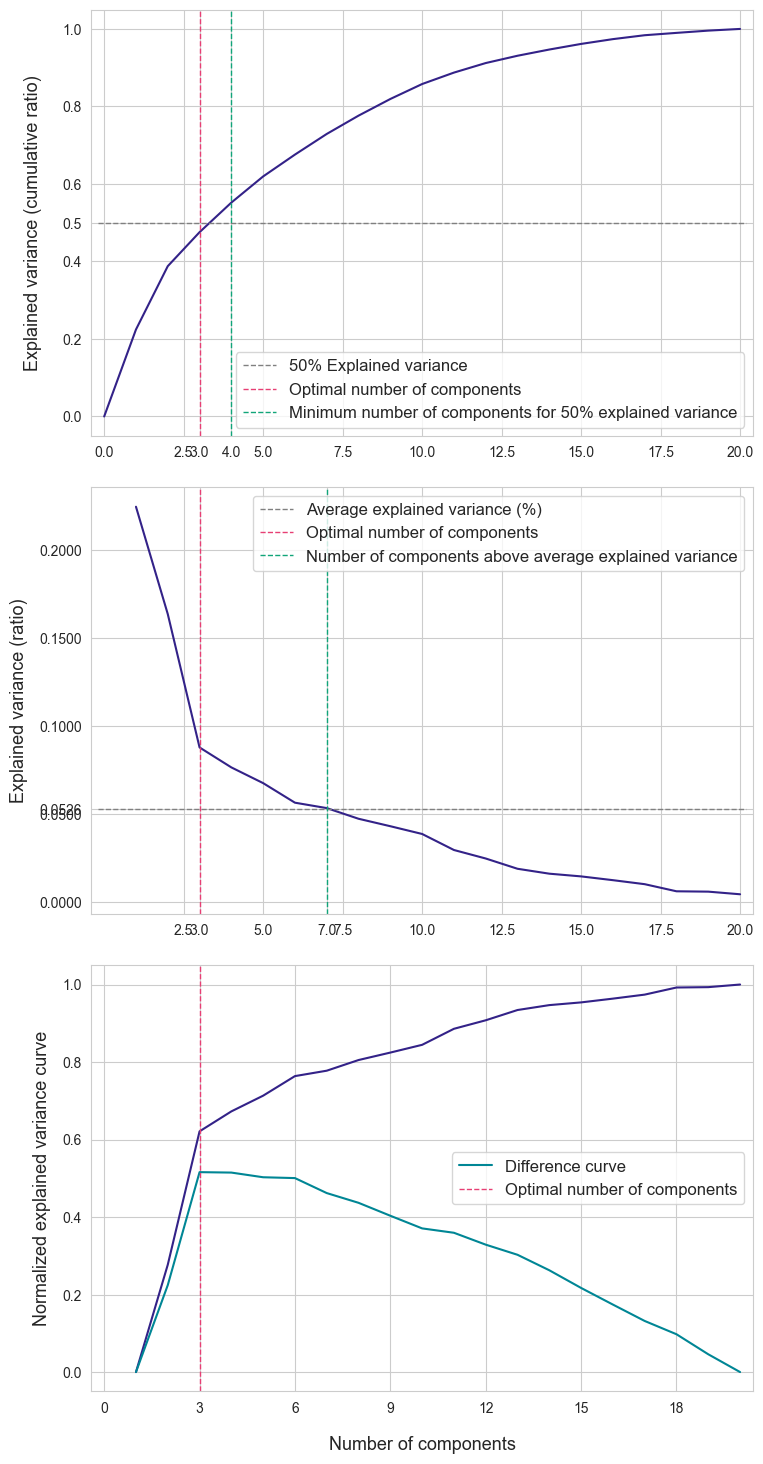

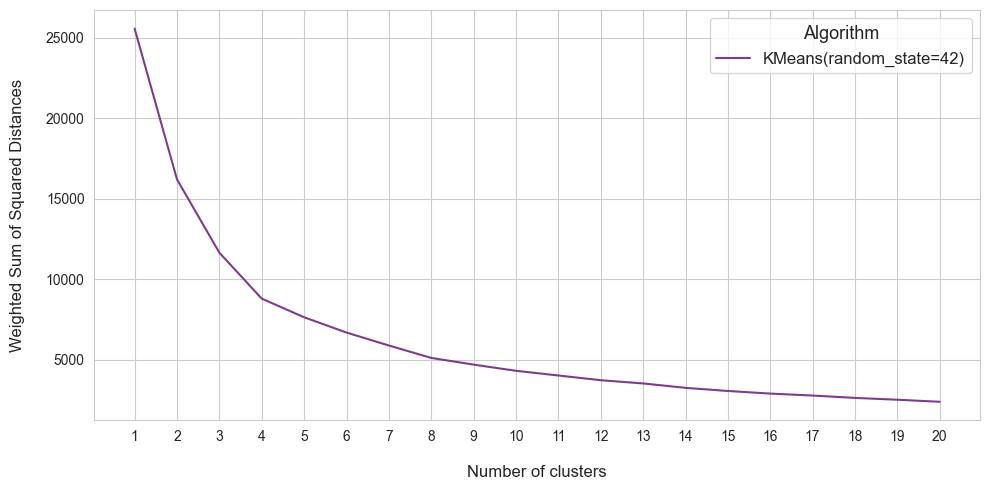

In [7]:
if not DimensioreductionPCA:
    scaler = StandardScaler()
    print(scaler.fit(datapd))
    Scaled_Data = scaler.transform(datapd)
    scaleddata = pd.DataFrame(Scaled_Data)
    display(scaleddata)
    x_train = tf.constant(scaleddata)
else:
    import warnings
    warnings.filterwarnings('ignore')
    x_train = tf.constant(datapd)
    from clearn.dimensionality_reduction import DimensionalityReduction
    dr = DimensionalityReduction(datapd, num_vars=datapd.columns, cat_vars=None, num_algorithm='pca', cat_algorithm='mca', num_kwargs=None, cat_kwargs=None)
    dfPCA = dr.transform(n_components=None, min_explained_variance_ratio=None)
    dr.plot_num_explained_variance(thres=0.5, output_path=None, savefig_kws=None)
    reduced_data = dfPCA.values

    from clearn.clustering import Clustering
    cl = Clustering(dfPCA, normalize=False)
    dffc = cl.compute_clusters(n_clusters=None, metric='inertia', max_clusters=20, prefix=None, weights=None)
    cl.plot_score_comparison(output_path=None, savefig_kws=None)
    best = list(set(dffc))[-1]
    print(best)

2
For num_clusters = 2, The average silhouette_score is: 0.4131
Davies-Bouldin index: 1.0330
Calinski-Harabasz index: 1554.3704
3
For num_clusters = 3, The average silhouette_score is: 0.4432
Davies-Bouldin index: 0.8544
Calinski-Harabasz index: 1605.6067
4
For num_clusters = 4, The average silhouette_score is: 0.4296
Davies-Bouldin index: 0.8183
Calinski-Harabasz index: 1708.3439
5
For num_clusters = 5, The average silhouette_score is: 0.3688
Davies-Bouldin index: 0.8624
Calinski-Harabasz index: 1577.3531
6
For num_clusters = 6, The average silhouette_score is: 0.3631
Davies-Bouldin index: 0.9786
Calinski-Harabasz index: 1517.0336
8
For num_clusters = 8, The average silhouette_score is: 0.3336
Davies-Bouldin index: 0.9268
Calinski-Harabasz index: 1536.1749
10
For num_clusters = 10, The average silhouette_score is: 0.3270
Davies-Bouldin index: 0.9212
Calinski-Harabasz index: 1471.5209
11
For num_clusters = 11, The average silhouette_score is: 0.3084
Davies-Bouldin index: 0.9541
Calinsk

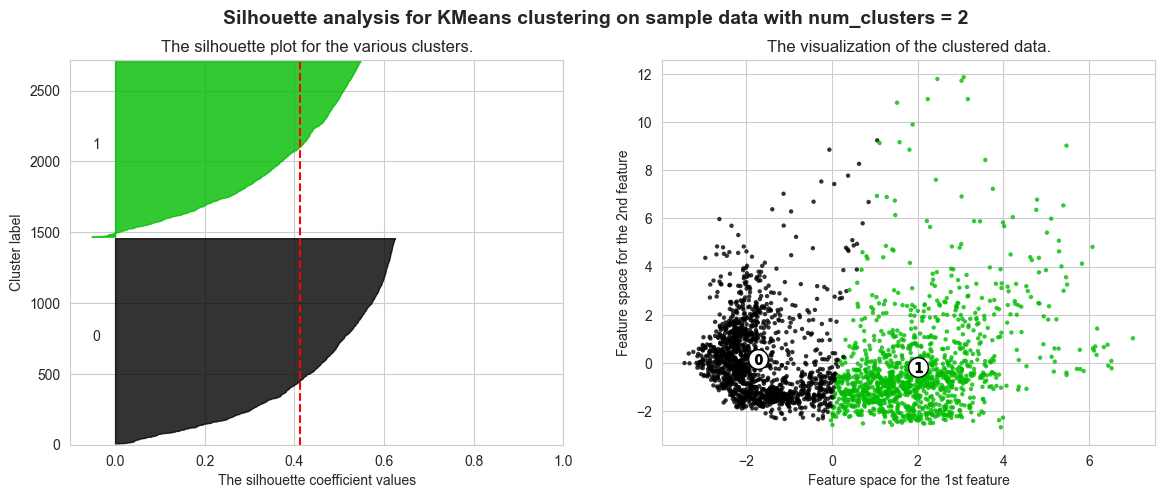

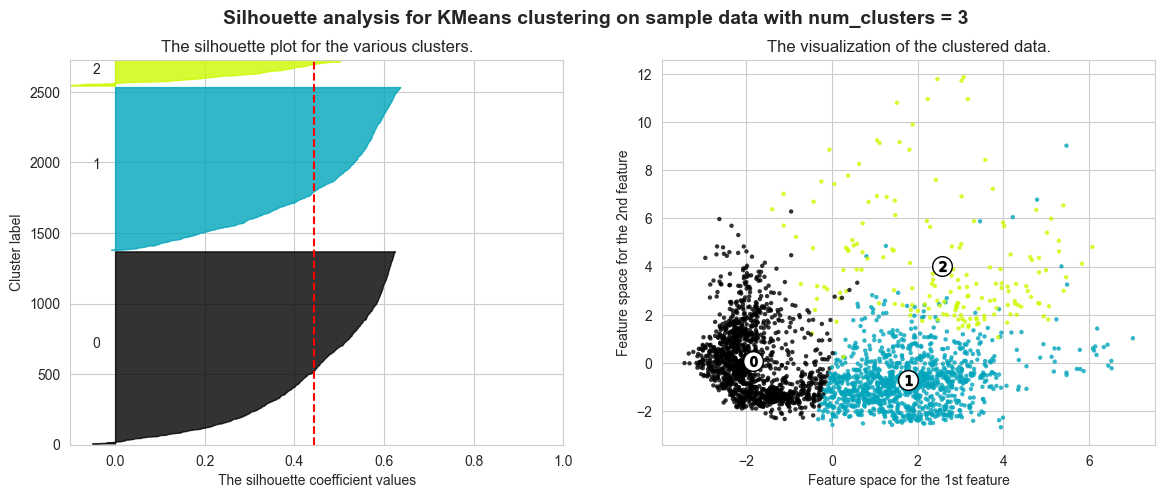

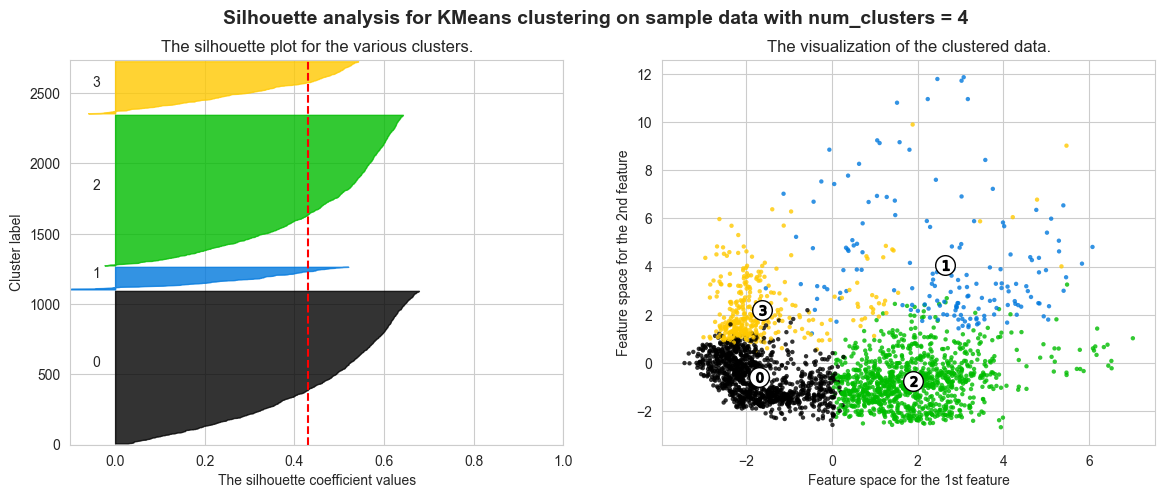

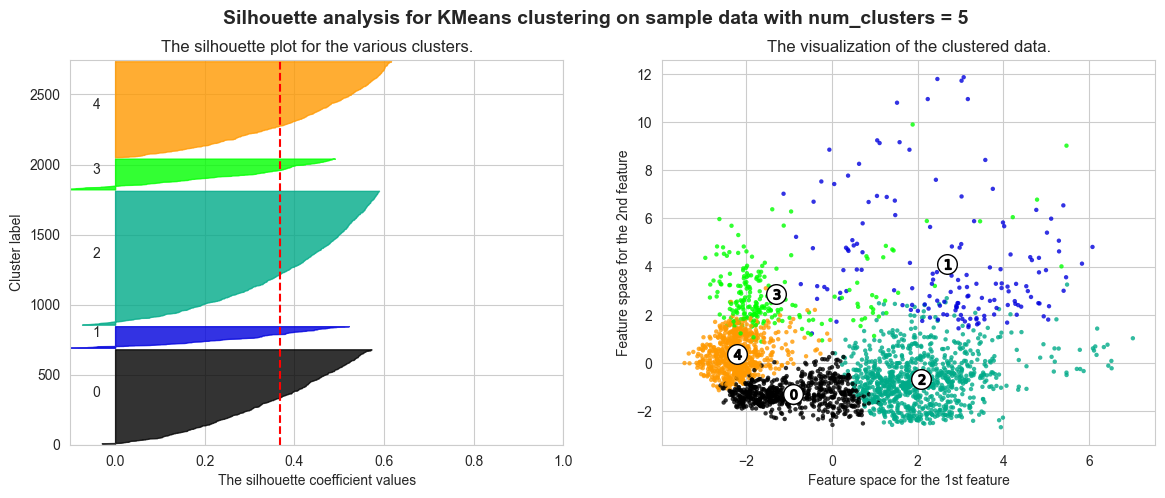

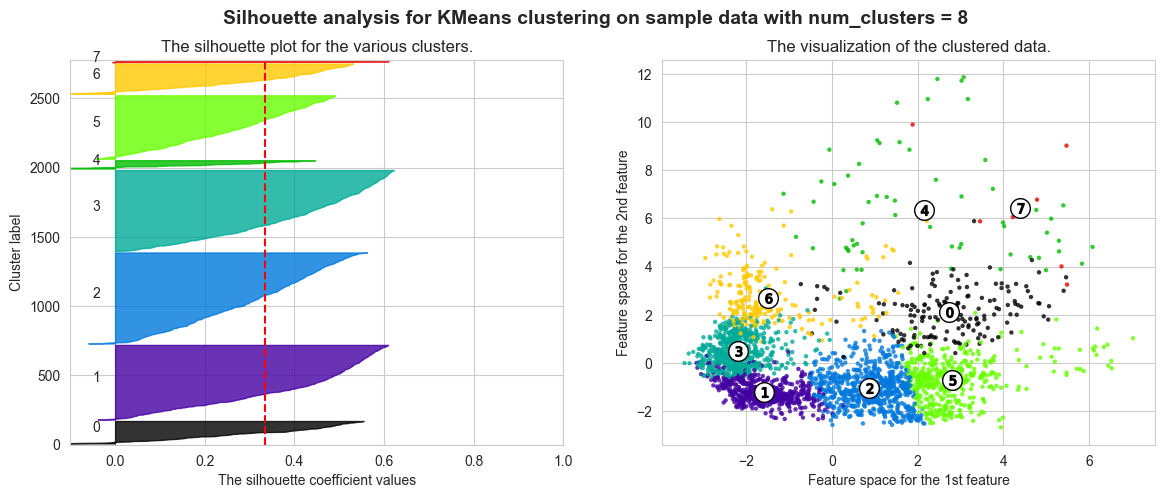

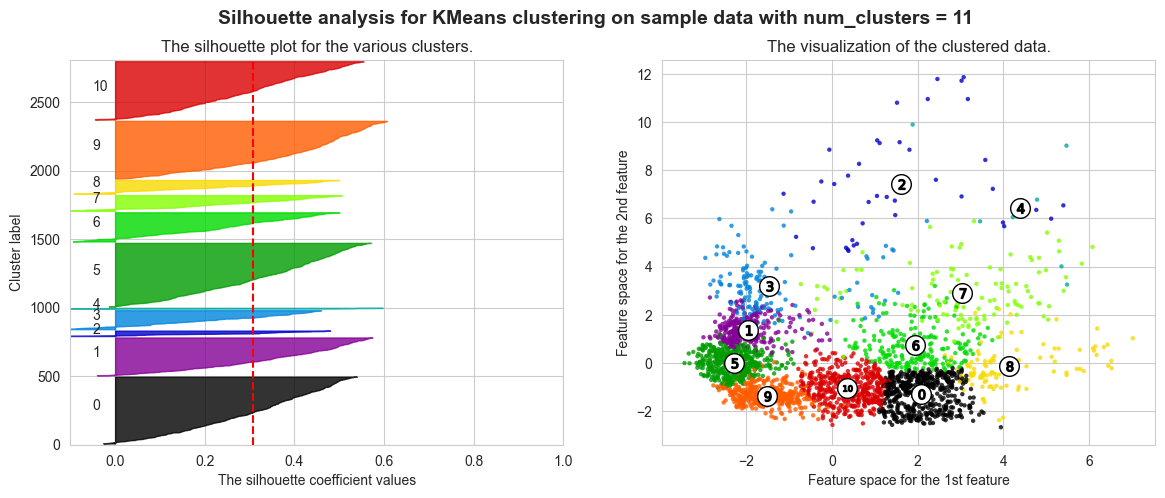

In [8]:
clusters = kmeans_clustering(
    reduced_data,
    num_clusters_list=[2, 3, 4, 5, 6, 8, 10, 11, 12],
    clusters_dbscan=False,
    clusters_hc=False,
    clusters_sc=False,
    tsne=False,
    param_dbscan=[0.5, 500]
)

In [9]:
# Choose number of clusters to evaluate SHAP values
Cluster = clusters[3]  # Select a specific clustering result, e.g., 5 clusters
print(set(Cluster))

# Create a DataFrame for the cluster labels
Clustersdf = pd.DataFrame(Cluster, index=datapd.index, columns=['Cluster'])
Clustersdf['Cluster'] = Clustersdf['Cluster'].astype(int)  # Keep as integer labels
cluster_counts = Clustersdf['Cluster'].sort_values().value_counts(sort= False)
print(cluster_counts)

{0, 1, 2, 3, 4}
Cluster
0    672
1    155
2    956
3    220
4    685
Name: count, dtype: int64


In [10]:
ClusterEvaluation =  True

def boxplot_linhas(ax, df, clase, yvalue, titulo, xlbl, ylbl, hue_, ylim=None, legendPos=False):
    if not df.empty:
        sns.boxplot(data=df, x=clase, y=yvalue, hue=hue_, width=0.7, linewidth=1, gap=.05, palette="rainbow", ax=ax)
        ax.axhline(1, color='red', linestyle='--', alpha=0.7)
        ax.set_title(titulo, fontsize=18)
        ax.set_xlabel(xlbl, fontsize=15)
        ax.set_ylabel(ylbl, fontsize=15)
        ax.tick_params(axis='both', labelsize=12)
        if legendPos:
            ax.legend(title='Clase', bbox_to_anchor=(1.22, 1), loc='upper right')
        else:
            ax.legend(title='Clase', loc='best')
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.grid()

if ClusterEvaluation:
    if cenario == 'all':
        df = datapd.merge(Clustersdf, on=['Dia', 'Hora', 'Cenario'], how='left')  # descomentar para analis de todos os cenarios
    else:
        df = datapd.merge(Clustersdf, on=['Dia', 'Hora', 'Cenario'], how='left') if isinstance(cenario, list) else datapd.merge(Clustersdf, on=['Dia', 'Hora'], how='left')

    num_regions = 5
    num_columns = 3
    num_rows = (num_regions + 1) // num_columns

    fig = plt.figure(figsize=(25, 15))
    gs = fig.add_gridspec(num_rows, num_columns)

    for i, region in enumerate(['AC-RO', 'Northeast', 'North', 'SE-CW', 'South']):
        row = i // num_columns
        col = i % num_columns

        dff = pd.melt(df[[f'OV DPI_PQ_{region}', f'UV DPI_PQ_{region}', f'OV DPI_PV_{region}', f'UV DPI_PV_{region}', 'Cluster']],
                            id_vars=['Cluster'],
                            value_vars=[f'OV DPI_PQ_{region}', f'UV DPI_PQ_{region}', f'OV DPI_PV_{region}', f'UV DPI_PV_{region}'],
                            ignore_index=False).sort_values(['Cluster', 'variable'])

        ax = fig.add_subplot(gs[row, col])
        boxplot_linhas(ax, dff, 'Cluster', 'value', '', 'Cluster', 'DPI', 'variable', ylim=None)

    plt.tight_layout()
    plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import shap
shap.initjs()

In [12]:
# Define the columns to use for training
# columns2 = ['PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL', 'PG_BIO', 'PL_MW',]
columns2 = []
# Create the DataFrame with the selected columns
datapd2 = flatdataframe(dfanalise, cenario, region, columns2, ACDCflux=False, Reserva=False, DPI=False, IndiceGroup=False, InfoPO=True, PImva_reg_nt=False, PImva=False, Busfeatures=True,Vanalysis='UV')
datapd2.fillna(0, inplace=True)

# Merge the features DataFrame with the clusters DataFrame
if cenario == 'all':
    datapd3 = datapd2.merge(Clustersdf, on=['Dia', 'Hora', 'Cenario'], how='left')
else:
    if isinstance(cenario, list):
        datapd3 = datapd2.merge(Clustersdf, on=['Dia', 'Hora', 'Cenario'], how='left')
    else:
        datapd3 = datapd2.merge(Clustersdf, on=['Dia', 'Hora'], how='left')

# Separate the features and labels
labels = ['Cluster']
columns_to_keep = datapd3.columns[~datapd3.columns.isin(labels)]
X = datapd3[columns_to_keep]
Y = datapd3[labels].values.ravel()  # Flatten the label array for compatibility

# Print the shape of the features and labels
print(f'Features shape: {X.shape}')
print(f'Labels shape: {Y.shape}')


Features shape: (2688, 115)
Labels shape: (2688,)


In [13]:
# Assuming X and Y are already defined as features and labels
Trainall = True
PipelineObject = False
shapValues = True

# Splitting the dataset
if Trainall:
    X_train, Y_train = X, Y
else:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    print(f'Training features shape: {X_train.shape}')
    print(f'Training labels shape: {Y_train.shape}')
    print(f'Testing features shape: {X_test.shape}')
    print(f'Testing labels shape: {Y_test.shape}')

# Define numerical features and preprocessing steps
numerical_features = [c for c in X_train.columns]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num, df_out=True)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocess', mapper),
    ('rf', model)
])

print(f'Total samples for training: {X_train.shape[0]}')

# Fit the model
if PipelineObject:
    print('========= PipelineObject ==========')
    pipeline.fit(X_train, Y_train)
    if Trainall:
        y_pred = pipeline.predict(X_train)
        Y_true = Y_train
    else:
        y_pred = pipeline.predict(X_test)
        Y_true = Y_test
else:
    model.fit(X_train, Y_train)
    if Trainall:
        y_pred = model.predict(X_train)
        Y_true = Y_train
    else:
        y_pred = model.predict(X_test)
        Y_true = Y_test

# Evaluation
accuracy = accuracy_score(Y_true, y_pred)
balanced_acc = balanced_accuracy_score(Y_true, y_pred)
f1 = f1_score(Y_true, y_pred, average='weighted')  # Use 'weighted' for multiclass

print(f'Accuracy: {accuracy:.4f}')
print(f'Balanced Accuracy: {balanced_acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print('\nClassification Report:')
print(classification_report(Y_true, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Total samples for training: 2688
Accuracy: 1.0000
Balanced Accuracy: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       672
           1       1.00      1.00      1.00       155
           2       1.00      1.00      1.00       956
           3       1.00      1.00      1.00       220
           4       1.00      1.00      1.00       685

    accuracy                           1.00      2688
   macro avg       1.00      1.00      1.00      2688
weighted avg       1.00      1.00      1.00      2688



In [14]:
if shapValues:
    if Trainall:
        X_test = X_train
        Y_test = Y_train

    if PipelineObject:
        explainer = shap.Explainer(pipeline['rf'], X_train)
        shap_values = explainer(X_test)
        
        shapeshap = np.shape(shap_values.values)
        print(f'In your case, your SHAP values have shape {shapeshap}, so you have SHAP values for multiple instances ({shapeshap[0]} instances in this case) and multiple features ({shapeshap[1]} features).')
    else:
        explainer_2 = shap.TreeExplainer(model)
        shap_values_2 = explainer_2.shap_values(X_test)

        shapeshap_2 = np.shape(shap_values_2)  
        print(f'In your case, your SHAP values have shape {shapeshap_2}, so you have SHAP values for multiple instances ({shapeshap_2[0]} instances in this case) and multiple features ({shapeshap_2[1]} features).')


In your case, your SHAP values have shape (2688, 115, 5), so you have SHAP values for multiple instances (2688 instances in this case) and multiple features (115 features).


In [15]:
class_names = np.unique(Y_test)

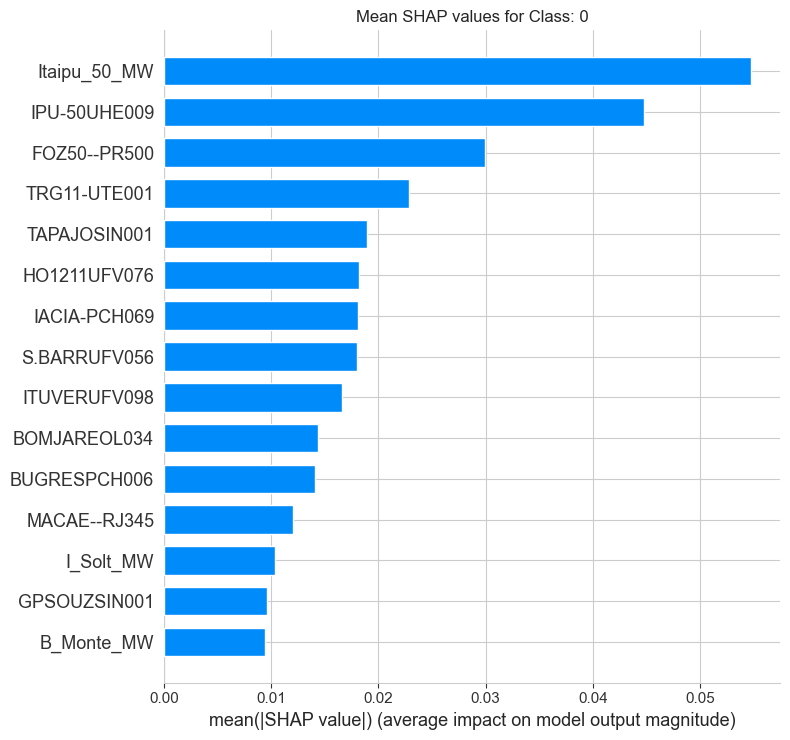

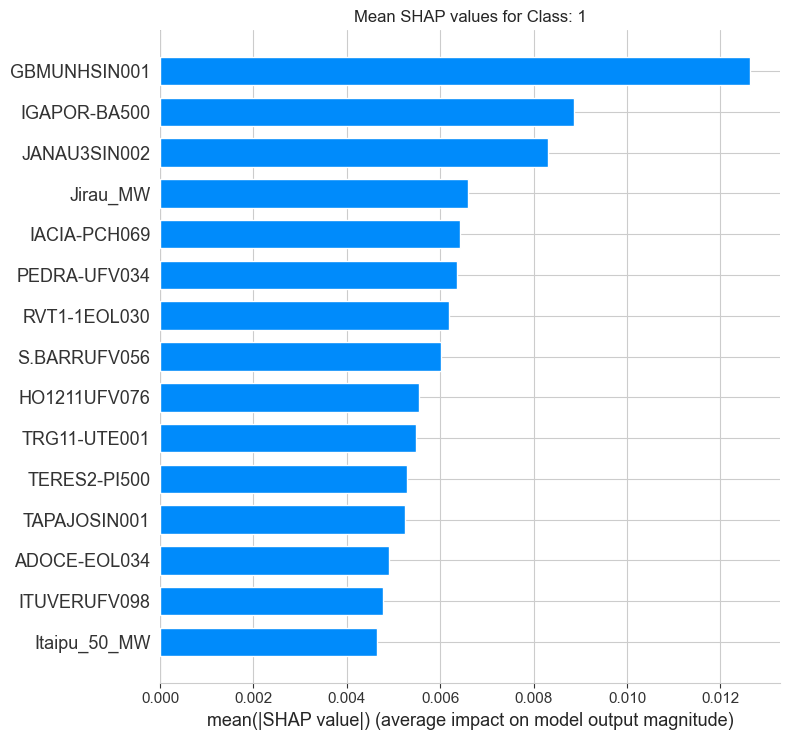

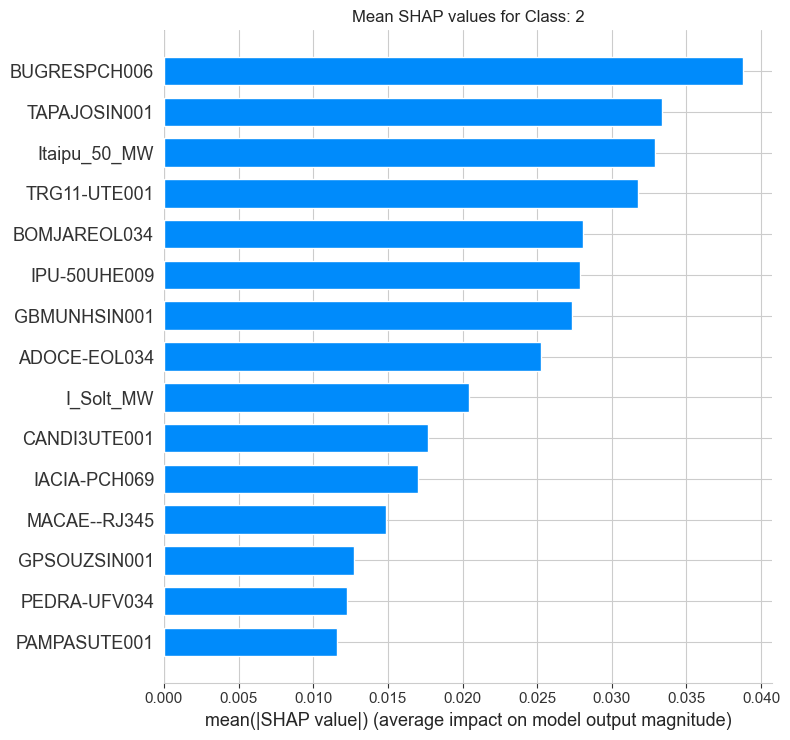

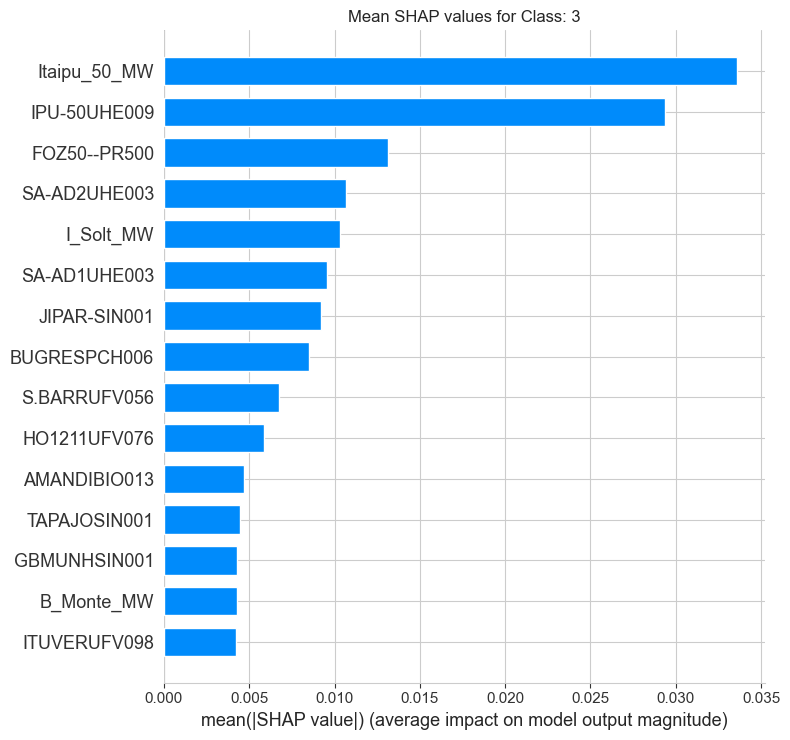

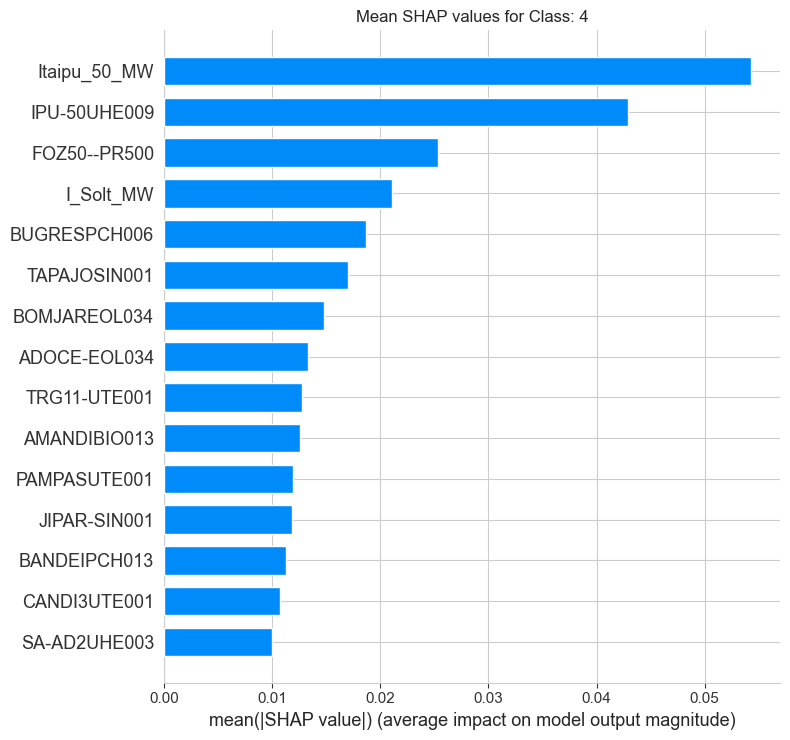

In [16]:
for i, class_name in enumerate(class_names):
    plt.figure()  # Create a new figure for each class
    plt.title(f'Mean SHAP values for Class: {class_name}')  # Set the title
    shap.summary_plot(shap_values_2[:,:,i], X_test, plot_type="bar", max_display=15, feature_names=X_test.columns)
    plt.show()

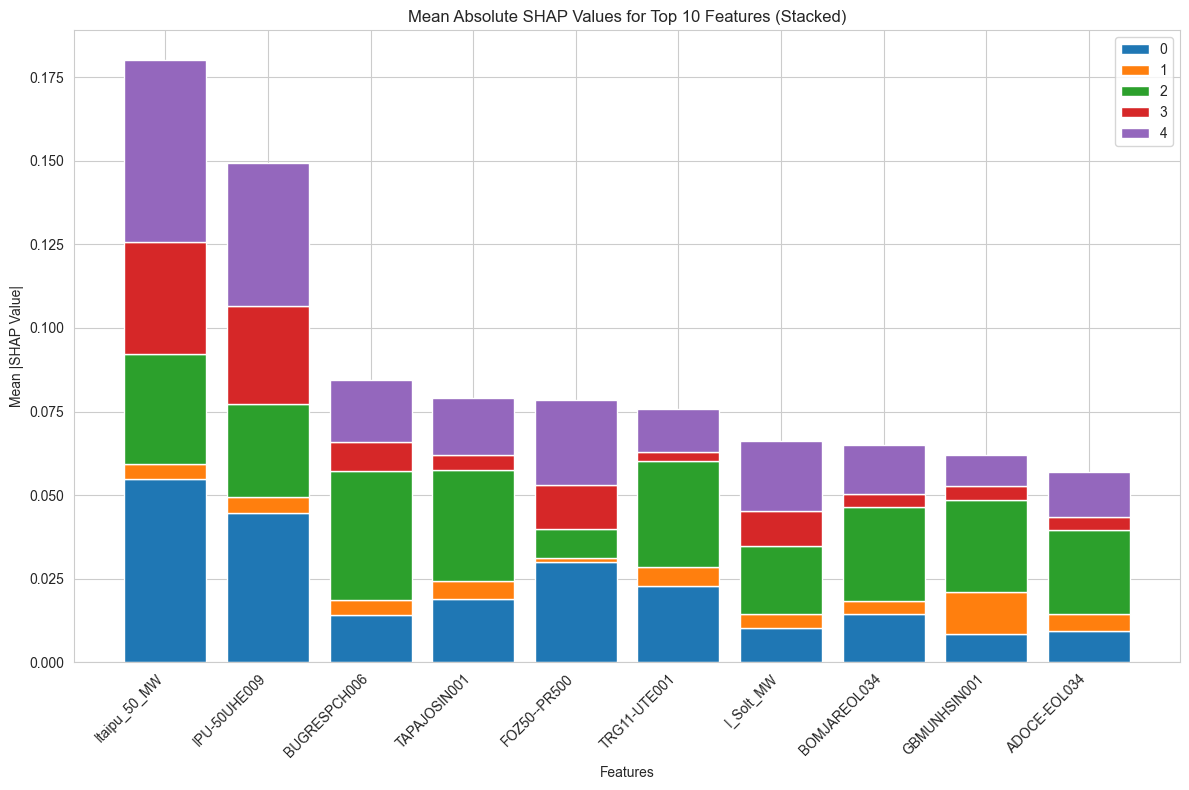

In [17]:
# Calculate mean absolute SHAP values for each feature per class
mean_shap_values_per_class = np.mean(np.abs(shap_values_2), axis=0)  # Shape: (123, 6)
# Calculate mean absolute SHAP values across all classes
mean_shap_values_agg = np.mean(mean_shap_values_per_class, axis=1)  # (123,)
# Get indices for sorting in descending order
sorted_indices = np.argsort(mean_shap_values_agg)[::-1]  # Descending order
# Get top 10 features and their SHAP values
top_10_features = X_test.columns[sorted_indices][:10]
top_10_shap_values = mean_shap_values_per_class[sorted_indices][:10, :]
# Plot stacked bar chart for top 10 features
plt.figure(figsize=(12, 8))
bottom = np.zeros(len(top_10_features))
for i, class_name in enumerate(class_names):
    plt.bar(
        top_10_features,
        top_10_shap_values[:, i],
        bottom=bottom,
        label=class_name,
    )
    bottom += top_10_shap_values[:, i]
# Add labels, title, and legend
plt.title('Mean Absolute SHAP Values for Top 10 Features (Stacked)')
plt.xlabel('Features')
plt.ylabel('Mean |SHAP Value|')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

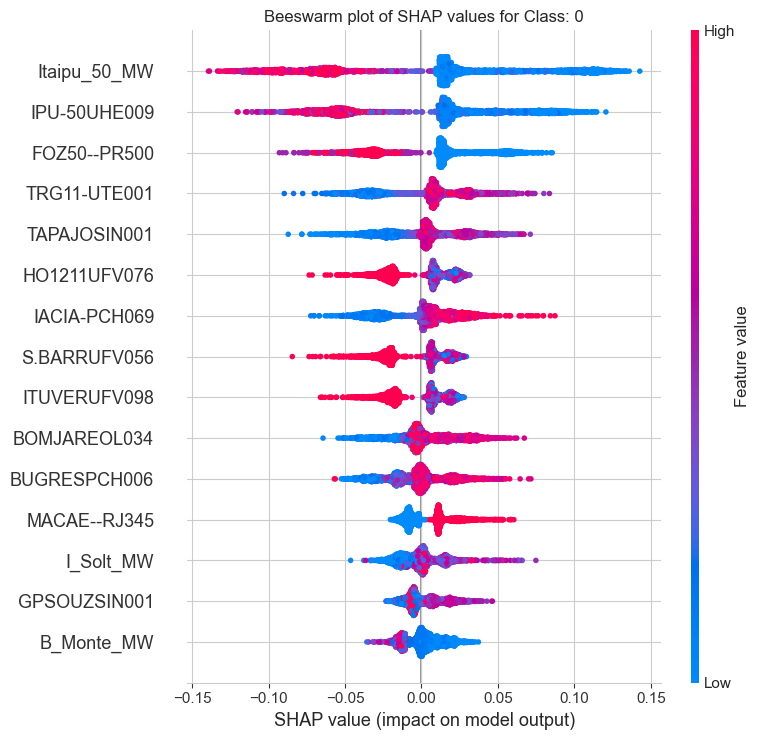

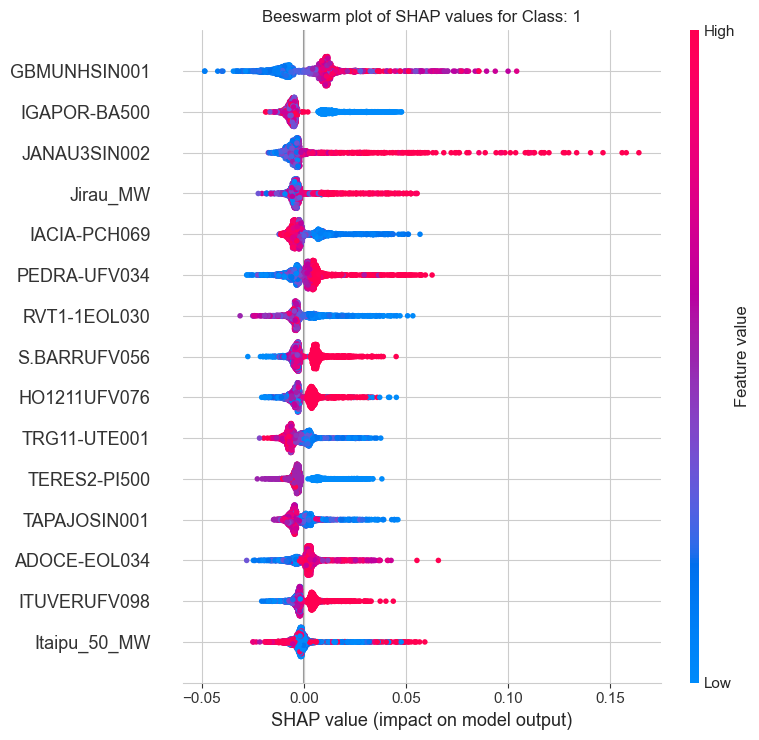

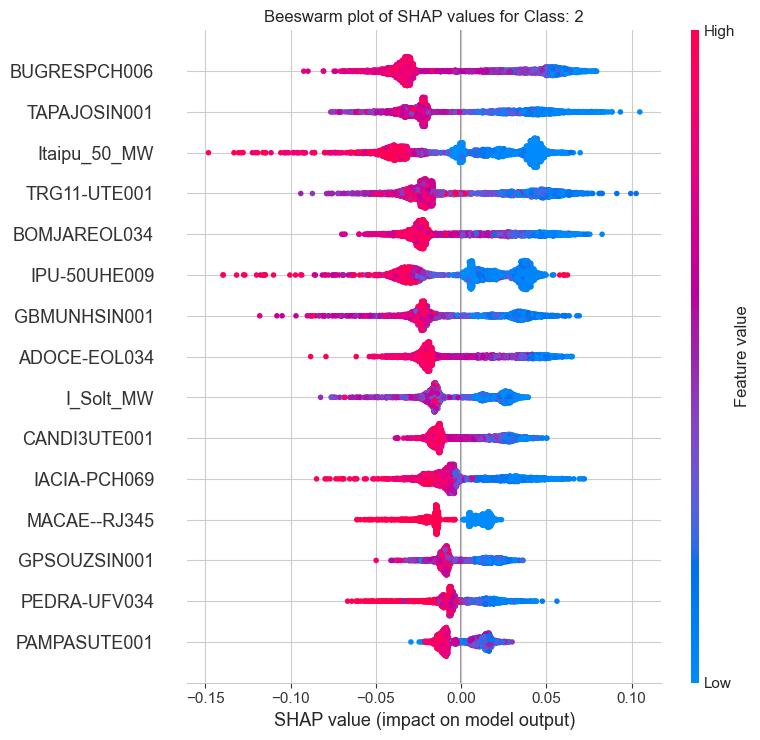

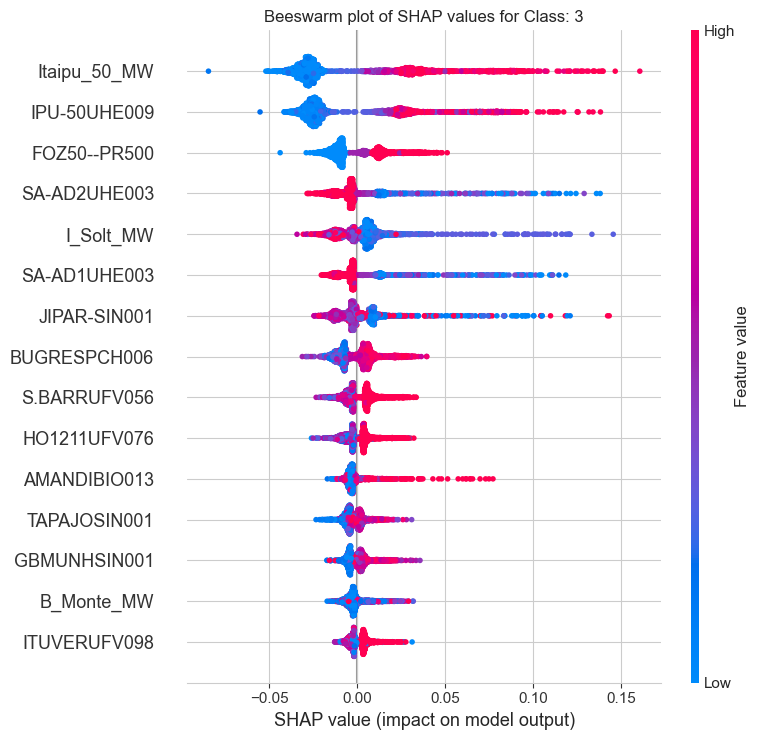

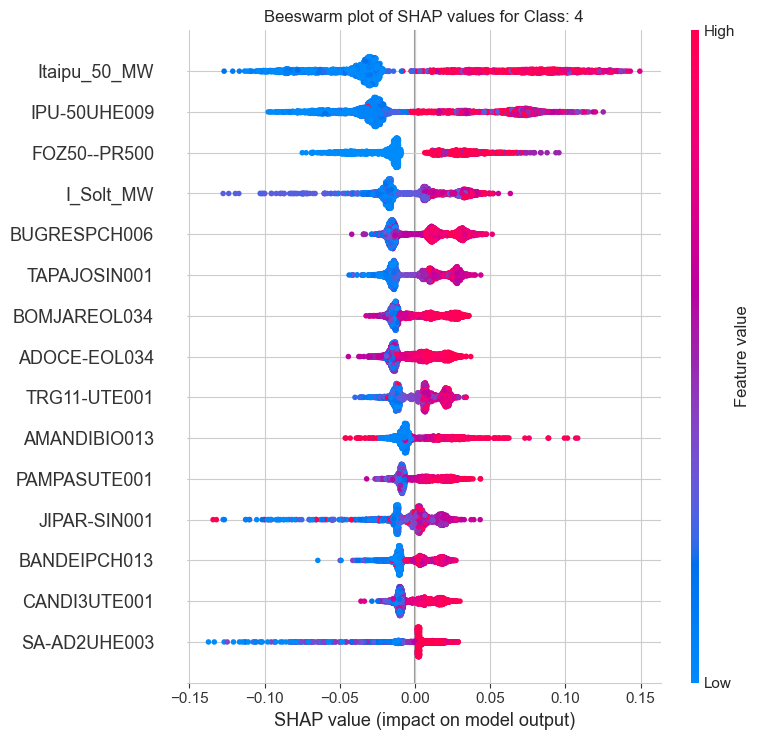

In [18]:
for i, class_name in enumerate(class_names):
    plt.figure()  # Create a new figure for each class
    plt.title(f'Beeswarm plot of SHAP values for Class: {class_name}')
    shap.summary_plot(shap_values_2[:,:,i], X_test, max_display=15)
    plt.show()

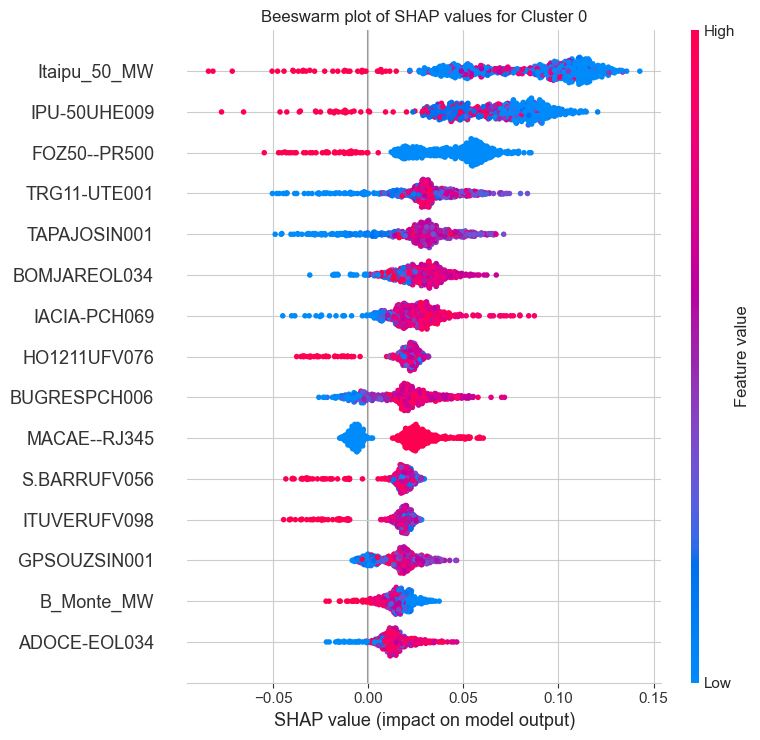

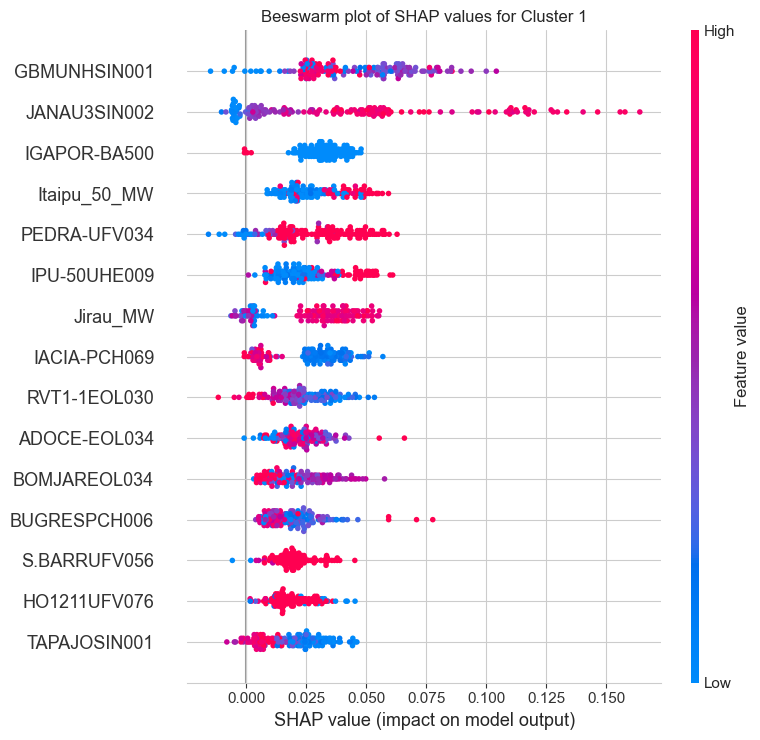

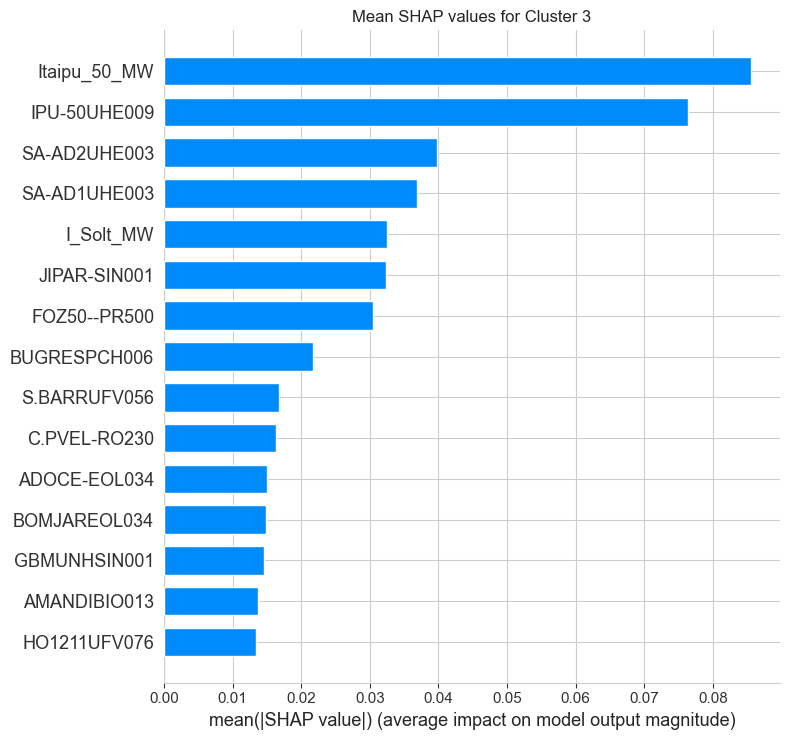

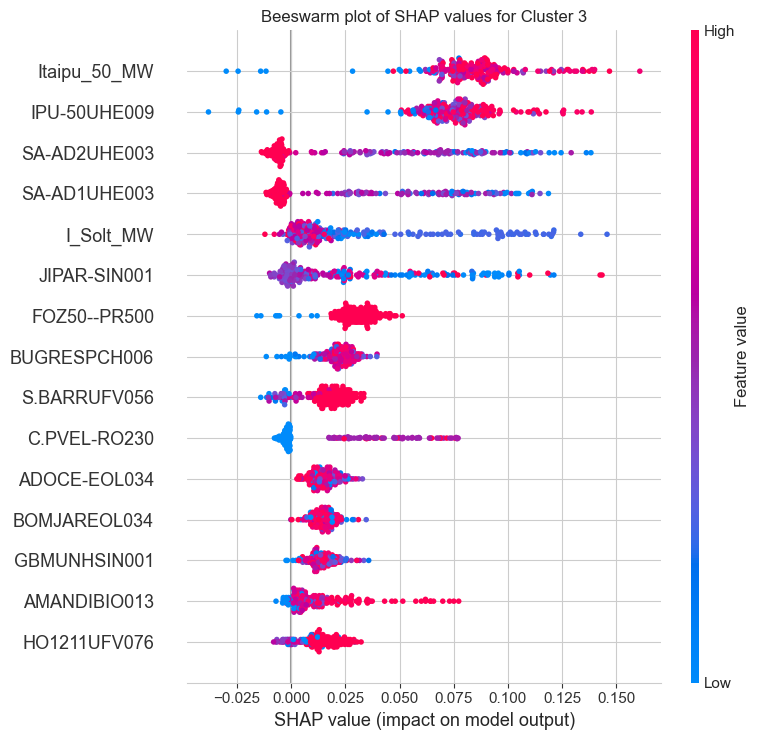

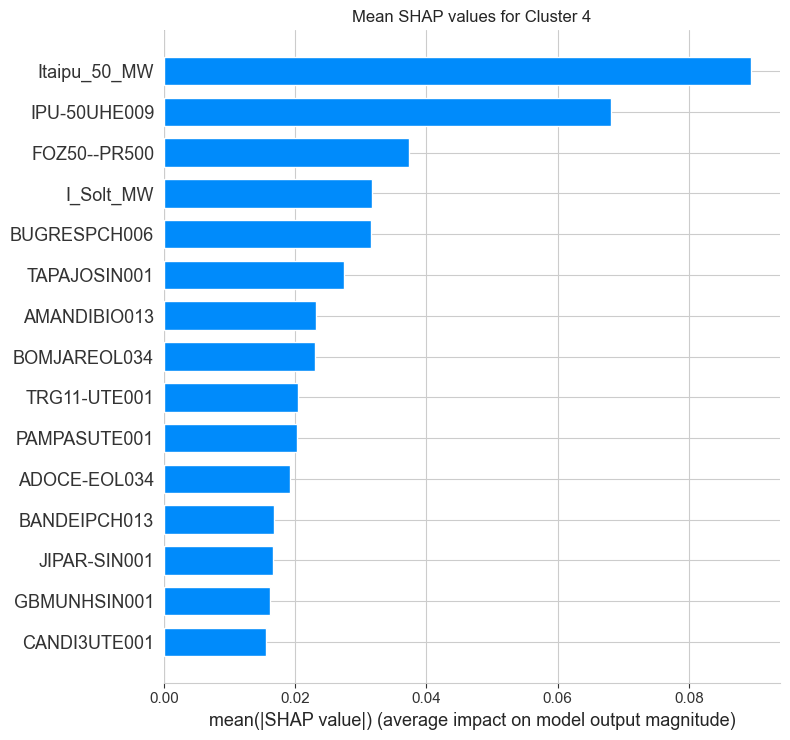

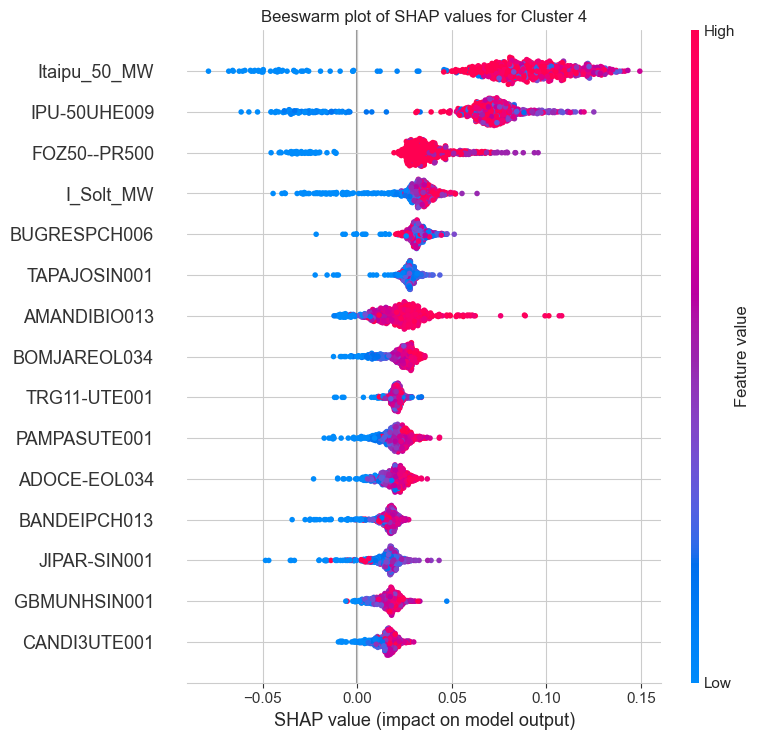

In [19]:
# Mean SHAP
for label in np.unique(Y_test):
    indices = np.where(Y_test == label)[0]
    shapvalues_label = shap_values_2[indices]
    # Mean SHAP
    plt.title(f'Mean SHAP values for Cluster {label}')
    shap.summary_plot(shapvalues_label[:,:,label], X_test, plot_type="bar", max_display=15)

    # Beeswarm plot
    plt.title(f'Beeswarm plot of SHAP values for Cluster {label}')
    shap.summary_plot(shapvalues_label[:,:,label], X_test.iloc[indices], max_display=15)

In [20]:
preds = model.predict(X_test)
new_shape_values = []
for i, pred in enumerate(preds):
    # get shap values for predicted class
    new_shape_values.append(shap_values_2[i][:,pred])

new_shape_values = np.array(new_shape_values)
print(new_shape_values.shape)

(2688, 115)


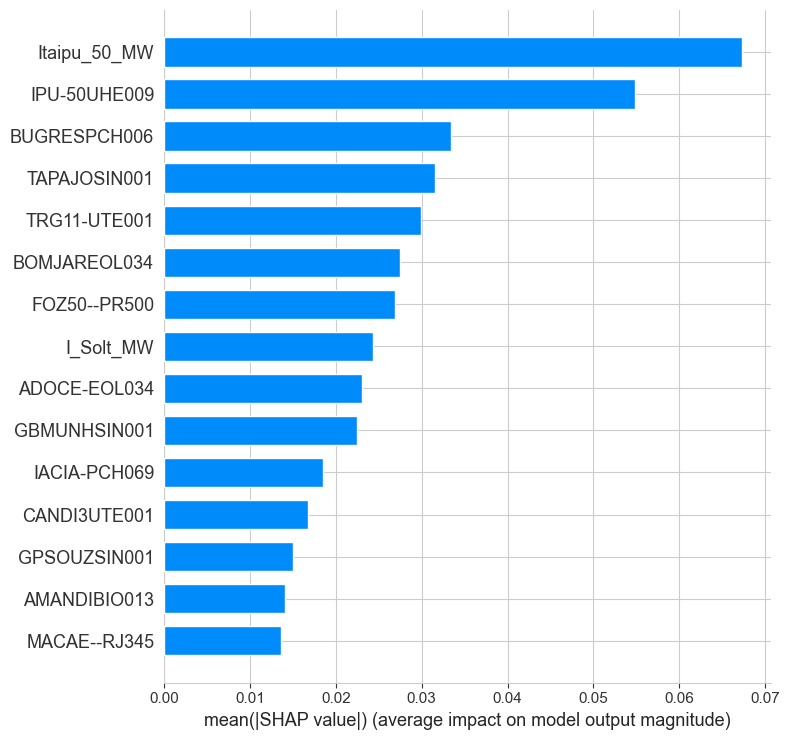

In [21]:
shap.summary_plot(new_shape_values, X_test, plot_type="bar", max_display=15)

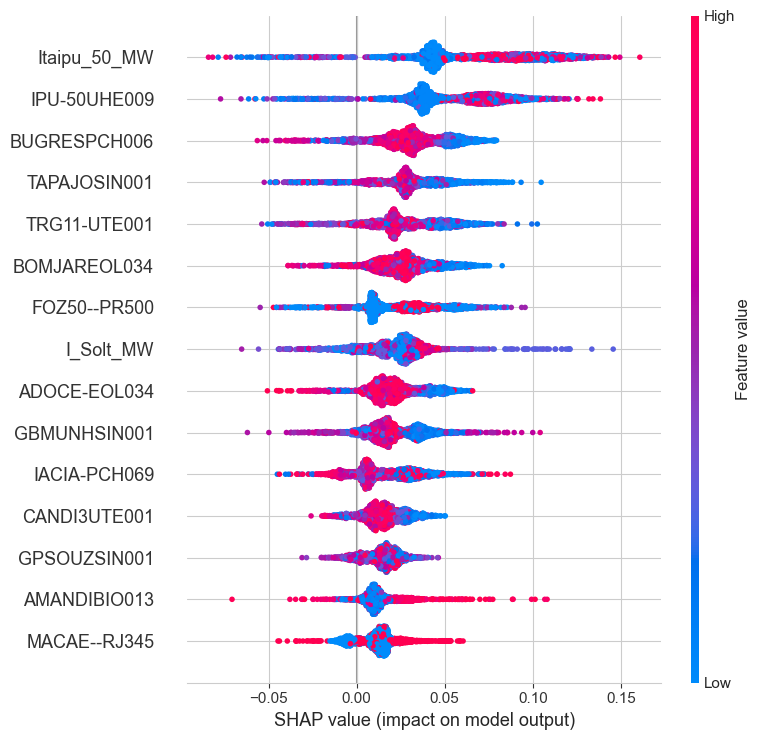

In [22]:
shap.summary_plot(new_shape_values, X_test, max_display=15)

In [23]:
shap_values_2_explainer = explainer_2(X_test)

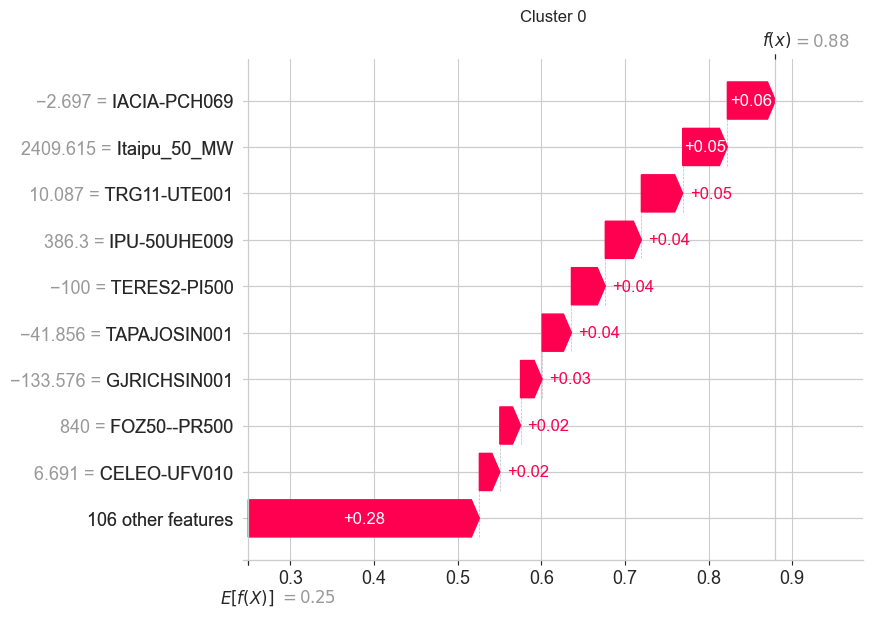

In [24]:
ittem = 25
# label = Y_test[ittem]
label = model.predict(X_test)[ittem]
plt.title(f'Cluster {label}')
shap.plots.waterfall(shap_values_2_explainer[ittem,:, label],max_display=10)

In [25]:
label = 1
indices = np.where(Y_test == label)[0]
shapvalues_label = shap_values_2_explainer[indices]
shap.plots.force(shapvalues_label[:,:, label]) # PV LOWER